In [19]:
import re
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
#get name of parent directory working drectory)
parent_dir = os.path.dirname(os.getcwd()) # get path to parent directory
parent_dir

'/Users/admin/Documents/MscProject'

## Phenotypic Data CSV cleaning
Phenotypic data is stored in a csv file, that requires pre-processing, for ease of reference I shall add filenames of extracted
data, into columns, and deal with any missing data.

### Raw phenotypic data

In [21]:
#path to original phenotype description file
df_p = os.path.join(parent_dir, 'phenotype_files/Phenotypic_V1_0b_preprocessed.csv')
raw_df = pd.read_csv(df_p)

In [22]:
raw_df.head() # at this stage only the subject identification features and  diagnosis classes are needed.

,Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,...,qc_rater_1,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3
0,1,50002,1,50002,PITT,no_filename,1,1,16.77,1,...,fail,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24
1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,1,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,1,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN
3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,2,...,OK,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN
4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,1,...,OK,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN


In [23]:
# extract necessary data
st1_df = raw_df[['SITE_ID','X','SUB_ID','FILE_ID','AGE_AT_SCAN','SEX','DSM_IV_TR','DX_GROUP']]
st1_df.head()

,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP
0,PITT,1,50002,no_filename,16.77,1,1,1
1,PITT,2,50003,Pitt_0050003,24.45,1,1,1
2,PITT,3,50004,Pitt_0050004,19.09,1,1,1
3,PITT,4,50005,Pitt_0050005,13.73,2,1,1
4,PITT,5,50006,Pitt_0050006,13.37,1,1,1


##  Updating File_ID field
File_ID data is neccesary  for data analysis since its an identifier for any data on a subject, and this field contains missing values. these missing values can be imputed using the fMRi data filenames.

In [ ]:
fMRI_dir = os.path.join(parent_dir, 'func_preproc') # subdirectory containing fMRI data

In [ ]:
fMRI_files= next(os.walk(fMRI_dir))[2] # acquire all fMRI file names
fMRI_files = [fMRI_files[i] for i in range(len(fMRI_files)) if 'nii.gz' in fMRI_files[i]] # limit to nifti files

In [ ]:
print(f' Number of fMRI files : {len(fMRI_files)} \n Number of rows in phenotypic file: {len(st1_df)}')

There are more subjects in the raw phenotypic data than there are fMRI files, these missing data pertains to fMRI scans that did not pass Quality control checks following preprocessing in the CPAC pipeline. the subject with fMRI data will be removed.

In [ ]:
present = []  # sub ids of rows with a corresponding fMRI file
for i in range(len(fMRI_files)):
    # use regex, every subject ID starts with 5 following by unique digit combination get subject ids of all present
    here = re.search('5\d+\d', fMRI_files[
        i]).group()
    present.append(int(here))

absent = []  # indexes of missing rows
for i in range(len(st1_df)):
    if st1_df.loc[i, 'SUB_ID'] not in present:
        absent.append(i)
len(st1_df) - len(absent) == len(fMRI_files)

In [ ]:
st1_df.iloc[absent]  # rows that do not have corrosponding fMRI data

In [ ]:
st1_df.drop(absent,inplace = True) # drop all rows with missing data, inplace
st1_df.reset_index(drop= True,inplace = True) # reset index

In [ ]:
len(st1_df) # it worked

In [ ]:
st1_df.head()

## Impute FILE_ID data

FILE_ID data is missing in some rows, this is problematic since it's the unique identifier that is necessary for model fitting

In [ ]:
file_ids = st1_df['FILE_ID']

In [ ]:
missing_index = []
for i,file in enumerate(file_ids):
    pattern = re.search('5\d+\d',file) # use regex to search if value contains a string matching subject id
    # if such string match is found append index to missing_index
    if pattern == None:
        missing_index.append(i)

In [ ]:
st1_df.loc[missing_index,'FILE_ID'].unique() # all missing values designated as no_filename

In [ ]:
len(missing_index)

In [ ]:
# the fmri filenames are of format {FILE_ID}_func_preproc.nii.gz these can be used to impute file id
st1_df.loc[missing_index]

In [ ]:
#get sub ids of all missing file ids and turn into str type
missing_subs = st1_df.loc[missing_index, 'SUB_ID']
missing_subs = [str(s) for s in missing_subs]

In [ ]:
# if sub id is in fmri file name extract file_id portion of filename and store in found
found = []
for i in range(len(missing_subs)):
    for f in fMRI_files:
        if missing_subs[i] in f:
            found.append(f.strip('_func_preproc.nii.gz'))

In [ ]:
# replace no_filename with correct File_ID
for i, ind in enumerate(missing_index):
    st1_df.loc[ind,'FILE_ID'] = found[i]

In [ ]:
#it worked!
st1_df.loc[missing_index,:]

In [ ]:
# save as pheno_clean.csv
save_p = os.path.join(parent_dir, 'phenotype_files/pheno_clean.csv')
st1_df.to_csv(save_p, index= False)

## Removing data with low temporal resolution
Referring to Notebook `EDA` there are fMRI files that contain less than 100 time points, this is lower than the required temporal resolution for calculating an accurate measure of dynamic correlation, so these shall be removed.


In [ ]:
st1_df.head()

In [ ]:
roi_all = [st1_df.FILE_ID[i] + '_rois_cc200.1D' for i in range(len(st1_df))]

In [ ]:
roi_dir = parent_dir + '/rois_cc200'


In [ ]:
pd.read_csv(os.path.join(roi_dir, roi_all[0]), sep='\t', lineterminator='\n').shape

In [ ]:
times = []
for i in range(len(roi_all)):
    roi = os.path.join(roi_dir, roi_all[i])# make path to fmri file
    dim = pd.read_csv(roi, sep='\t', lineterminator='\n').shape # get length of temporal dimension
    times.append(dim[0])# get size of last dimension time

low_indexes = []
low_times = []
for i, time in enumerate(times):
    if times[i] < 116:
        low_indexes.append(i)
        low_times.append(time)

In [ ]:
len(roi_all),len(low_indexes)

In [ ]:
low_times

In [ ]:
st1_df.loc[low_indexes] # The data with low temporal resolution

In [ ]:
st1_df.drop(low_indexes, inplace=True) # Drop the rows with low temporal resolution

In [ ]:
st1_df.reset_index(inplace= True, drop=True)# reset index

## Removing subjects with missing value ROIs in CC200 Data
Some sujects contain time series data with a flat-line this is considered to be missing data, and any subjects with a flat-line roi time series is to be removed

In [ ]:
# get path to every roi time series file
roi_paths = [os.path.join(parent_dir, 'rois_cc200', st1_df.FILE_ID[i] + '_rois_cc200.1D' )
             for i in range(len(st1_df))]

In [ ]:
# if a roi time series contains null data store in null_indexes
null_indexes = []
#iterate over ever roi file
for i, ts in enumerate(roi_paths):
    # load roi time series file
    df = pd.read_csv(ts, sep='\t', lineterminator='\n')
    # initialise null_yes if 0 then no null values in time series data
    null_yes = 0
    # iterate over every column (ROI)
    for r in range(df.shape[1]):
        # if roi time series only has one unique value its a flat-line therefore null
        if len(df.iloc[:,r].unique()) == 1:
            # if flat_line is detected make null_yes = 1 and skip to next data file
            null_yes += 1
            pass
    # if null_yes is not 0 then thre is a flat line in the time_series
    if null_yes > 0:
        null_indexes.append(i)

In [ ]:
#load example of null value detection
null_exp = pd.read_csv(roi_paths[null_indexes[0]], sep='\t', lineterminator='\n')

In [ ]:
# get column indexes of missing values
[i for i in range(null_exp.shape[1]) if len(null_exp.iloc[:,i].unique()) == 1]

In [ ]:
# it worked
null_exp.iloc[:, [51,175]]

In [ ]:
# 48 samples contain missing values
len(null_indexes)

In [ ]:
# approximatly 4.5% of all data contain missing values at can be removed, not too costly
len(null_indexes)/ len(st1_df)

In [ ]:
st1_df.drop(null_indexes, axis=0, inplace =True)
st1_df.reset_index(drop=True, inplace=True)

In [ ]:
# save file to phenotype_files/
st1_df.to_csv(os.path.join(parent_dir, 'phenotype_files/pheno_nn.csv'), index = False)

# Checking for Class distribution

In [3]:
parent_dir =os.path.dirname(os.getcwd())
pheno_dir = os.path.join(parent_dir, 'phenotype_files')
df_path = os.path.join(pheno_dir, 'pheno_clean.csv')

In [4]:
df = pd.read_csv(df_path) # read phenotype file
df.head()

,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP
0,PITT,1,50002,Pitt_0050002,16.77,1,1,1
1,PITT,2,50003,Pitt_0050003,24.45,1,1,1
2,PITT,3,50004,Pitt_0050004,19.09,1,1,1
3,PITT,4,50005,Pitt_0050005,13.73,2,1,1
4,PITT,5,50006,Pitt_0050006,13.37,1,1,1


In [5]:
df= df.loc[:,['FILE_ID','DSM_IV_TR','DX_GROUP']] # these columns are needed, the file ID and the two targets, binary: DX_Group, and Multi Class DSM_IV_TR
df.head()

,FILE_ID,DSM_IV_TR,DX_GROUP
0,Pitt_0050002,1,1
1,Pitt_0050003,1,1
2,Pitt_0050004,1,1
3,Pitt_0050005,1,1
4,Pitt_0050006,1,1


#### Target Classes
##### Binary : `DX_GROUP`
- 1: Autism
- 2: Control

##### Multi-class: `DSM_IV_TR`
- 0: Control
- 1: Autism
- 2: Aspergers
- 3: PDD-NOS (Pervasive Developmental Disorder-Not Otherwise Specified)
- 4: Aspergers or PDD-NOS

In [6]:
bin_labels = ['Autism','Control']
mult_labels = ['Nan','Control','Autism','Aspergers', 'PDD-NOS','Aspergers/PDD']

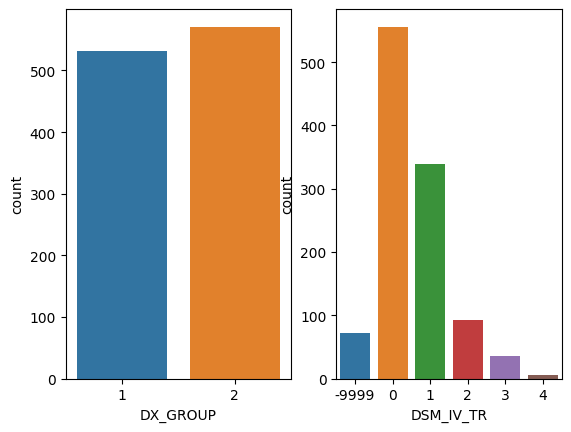

In [7]:
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2)
sns.countplot(df, x = 'DX_GROUP', ax=ax0)
sns.countplot(df, x = 'DSM_IV_TR', ax=ax1)
plt.show()
plt.show()

Target classes are balanced, a 0.2 train/test split will be carried out using scikit-learn's train_test_split module
The multi-class labels are problematic the -9999 class is not mentioned in the ABIDE dataset details, and the classes are heavily unbalanced.

### What's happening with -9999 in DSM_IV_TR?

In [8]:
check_df = df[['FILE_ID','DX_GROUP', 'DSM_IV_TR']]

In [9]:
check_df.loc[0, 'FILE_ID']

'Pitt_0050002'

In [10]:
len('_0050002') #length of subject id string

8

In [11]:
non_standard = check_df[check_df["DSM_IV_TR"]== -9999]
site = [file[:-8] for file in non_standard['FILE_ID']] # remove subject id from file id leaving site id
non_standard['SITE'] = site # add site ids to the non_stadard dataframe
non_standard

/var/folders/0k/w62sf0c17hs15h730mmdkmj40000gn/T/ipykernel_5576/3830846138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_standard['SITE'] = site # add site ids to the non_stadard dataframe


,FILE_ID,DX_GROUP,DSM_IV_TR,SITE
93,OHSU_0050142,1,-9999,OHSU
94,OHSU_0050143,1,-9999,OHSU
95,OHSU_0050144,1,-9999,OHSU
96,OHSU_0050145,1,-9999,OHSU
97,OHSU_0050146,1,-9999,OHSU
...,...,...,...,...
873,Stanford_0051195,2,-9999,Stanford
874,Stanford_0051196,2,-9999,Stanford
875,Stanford_0051197,2,-9999,Stanford
876,Stanford_0051198,2,-9999,Stanford


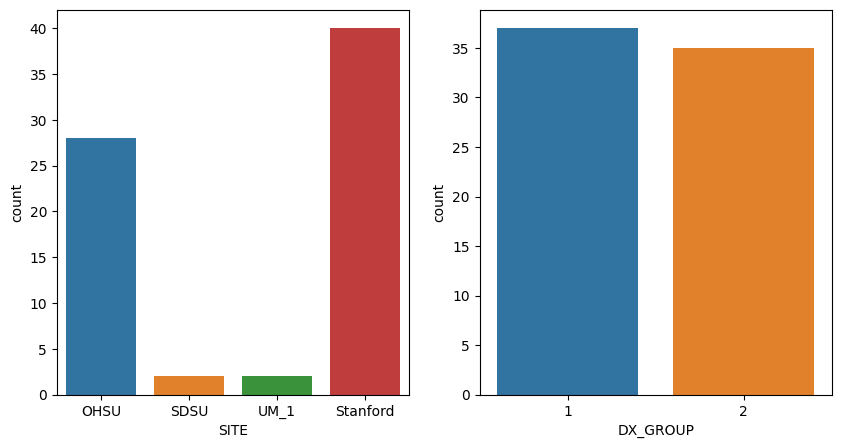

In [12]:
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.countplot(non_standard, x = 'SITE', ax =ax0) # number of non_standard entries in each site
sns.countplot(non_standard, x = 'DX_GROUP', ax =ax1)
plt.show()

In [13]:
non_standard_path = os.path.join(pheno_dir, 'multiclass_ns.csv') # save path for the non_standard file, save as multiclass_ns.csv
non_standard.to_csv(non_standard_path, index= False)

## Splitting data with no null values

In [14]:
# import the phenotype file with no null value timeseries data from cc200 atlas
nn_path = os.path.join(pheno_dir, 'pheno_nn.csv')
nn_df = pd.read_csv(nn_path)

In [15]:
nn_df.head()

,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP
0,PITT,1,50002,Pitt_0050002,16.77,1,1,1
1,PITT,2,50003,Pitt_0050003,24.45,1,1,1
2,PITT,3,50004,Pitt_0050004,19.09,1,1,1
3,PITT,4,50005,Pitt_0050005,13.73,2,1,1
4,PITT,5,50006,Pitt_0050006,13.37,1,1,1


In [16]:
nn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SITE_ID      1026 non-null   object 
 1   X            1026 non-null   int64  
 2   SUB_ID       1026 non-null   int64  
 3   FILE_ID      1026 non-null   object 
 4   AGE_AT_SCAN  1026 non-null   float64
 5   SEX          1026 non-null   int64  
 6   DSM_IV_TR    1026 non-null   int64  
 7   DX_GROUP     1026 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 64.2+ KB


In [17]:
nn_df= nn_df.loc[:,['SUB_ID','FILE_ID','DX_GROUP']]

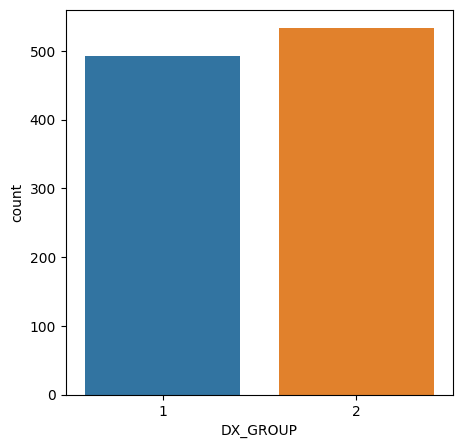

In [18]:
plt.figure(figsize=(5,5))
sns.countplot(nn_df, x = 'DX_GROUP')
plt.show()

The removal of subjects with null values did not seem to unduly affect the ratio between the two diagnostic classes